In [1]:
%load_ext lab_black

In [1]:
import os

os.chdir("/cerea_raid/users/dumontj/dev/coco2/inv")
import numpy as np
import sys
import pandas as pd
import xarray as xr
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Optional
import matplotlib_functions as mympf

mympf.setMatplotlibParam()
plt.viridis()
import pickle
from include.generators import ScaleDataGen
from saver import Saver
from include.callbacks import get_modelcheckpoint, ExtraValidation
import model_eval
from Data import Data_train, Data_eval
import wandb
from wandb.keras import WandbCallback, WandbMetricsLogger
import models.reg as rm
import models.seg as sm
import tensorflow as tf
from dataclasses import dataclass, field
from icecream import ic

from keras.utils import plot_model

from keras import backend as K

2024-01-16 15:03:39.353738: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-16 15:03:39.353778: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-16 15:03:39.353801: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-16 15:03:39.360671: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
wandb: ERROR Unable to patch Tensorflow/Ke

<Figure size 1920x1440 with 0 Axes>

## Real EfficientNetB0 (with U-net)

In [8]:
seg_builder = sm.Seg_model_builder(name="Unet_efficientnetb0", input_shape=[64, 64, 1])
model = seg_builder.get_model()
model.count_params()
model.summary(expand_nested=True)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 64, 64, 1)]       0         
                                                                 
 tf.__operators__.getitem (  (None, 64, 64, 1)         0         
 SlicingOpLambda)                                                
                                                                 
 noise_0 (GaussianNoise)     (None, 64, 64, 1)         0         
                                                                 
 concatenate (Concatenate)   (None, 64, 64, 1)         0         
                                                                 
 normalization (Normalizati  (None, 64, 64, 1)         3         
 on)                                                             
                                                                 
 model_4 (Functional)        (None, 64, 64, 1)         1011

## EfficientNetB0

In [2]:
reg_builder = rm.Reg_model_builder(name="efficientnet", input_shape=[32, 32, 3])
model = reg_builder.get_model()
model.count_params()
model.summary(expand_nested=True)

2024-01-16 15:03:47.846878: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14578 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 32, 32, 3)]       0         
                                                                 
 efficientnetb0 (Functional  (None, 4, 4, 1280)        477306    
 )                                                               
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_1 (InputLayer)       [(None, 32, 32, 3)]       0        |
|                                                               |
| stem_conv (Conv2D)         (None, 32, 32, 32)        864      |
|                                                               |
| stem_bn (BatchNormalizati  (None, 32, 32, 32)        128      |
| on)                                                           |
|                                                               |
| stem_activation (Activati  (None, 32, 32, 32)        0     

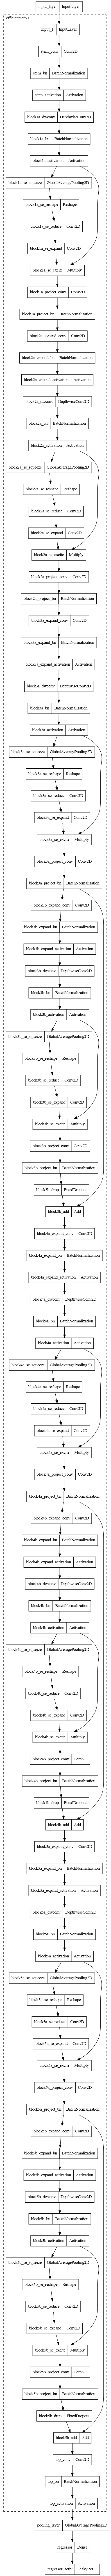

In [5]:
plot_model(model, expand_nested=True)

## Transformer

In [3]:
reg_builder = rm.Reg_model_builder(name="CCT")
model = reg_builder.get_model()
model.count_params()
model.summary(expand_nested=True)

2024-01-03 18:41:23.148049: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46863 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:3b:00.0, compute capability: 8.6
2024-01-03 18:41:23.148599: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46863 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:af:00.0, compute capability: 8.6


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 64, 64, 3)]       0         
                                                                 
 model (Functional)          (None, 16384)             138688    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_1 (InputLayer)       [(None, 64, 64, 3)]       0        |
|                                                               |
| cct_tokenizer (CCTTokeniz  (None, 256, 64)           38592    |
| er)                                                           |
|                                                               |
| position_embedding (Posit  (None, 256, 64)           16384    |
| ionEmbedding)                                                 |
|                                                               |
| tf.__operators__.add (TFO  (None, 256, 64)           0   

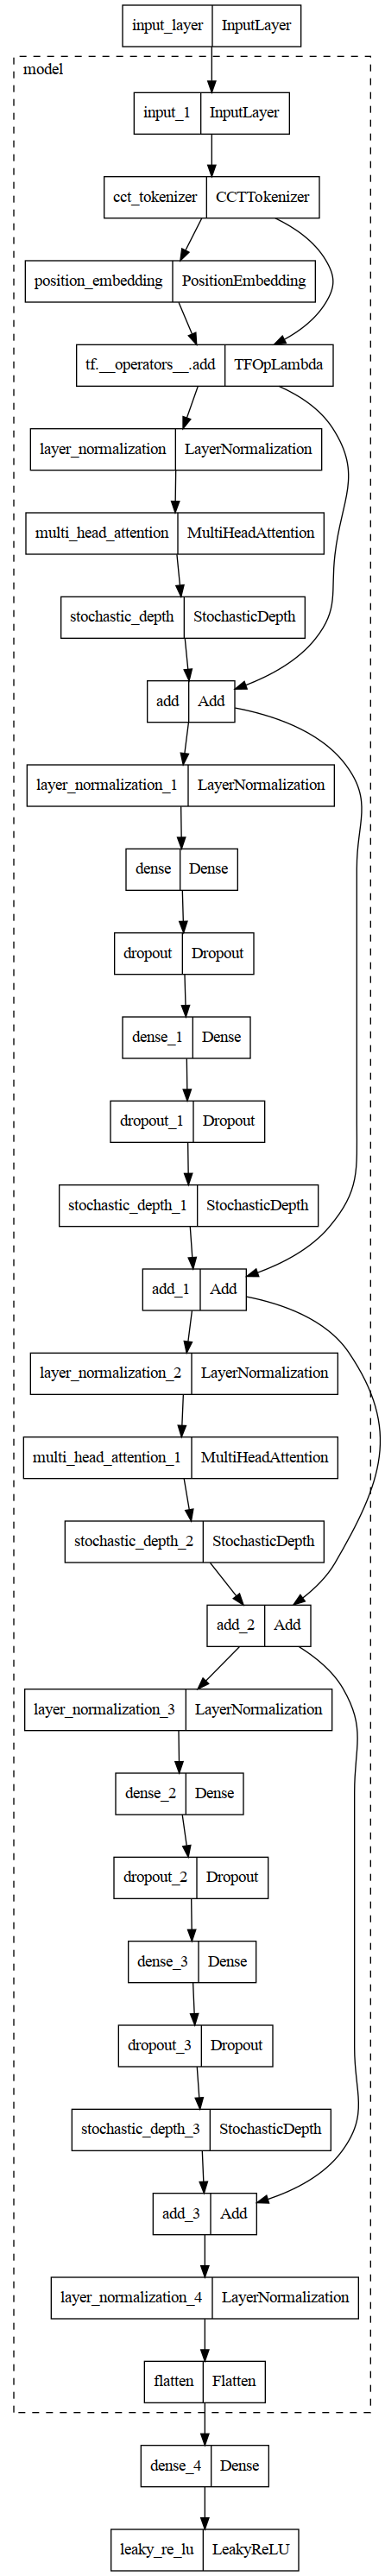

In [4]:
plot_model(model, expand_nested=True)

In [5]:
image = np.random.normal(size=(32, 64, 64, 3))

In [6]:
model.compile()

In [7]:
model(image)

2024-01-03 18:41:37.044029: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-01-03 18:41:37.156916: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-03 18:41:37.317571: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[-0.84627545],
       [-0.952154  ],
       [-1.0806277 ],
       [-0.8315323 ],
       [-0.98574454],
       [-0.9683492 ],
       [-0.63451904],
       [-1.0633568 ],
       [-0.83883697],
       [-0.8464434 ],
       [-0.99218965],
       [-1.1231668 ],
       [-0.8620052 ],
       [-0.90192217],
       [-0.9669742 ],
       [-0.78146505],
       [-1.0833278 ],
       [-0.90877813],
       [-1.053176  ],
       [-0.89486104],
       [-0.9087396 ],
       [-0.88296276],
       [-1.0626462 ],
       [-1.011677  ],
       [-0.71278274],
       [-1.1143758 ],
       [-0.91837597],
       [-0.96122843],
       [-0.8124961 ],
       [-0.87986153],
       [-1.0757701 ],
       [-0.9721853 ]], dtype=float32)>

## UNET

In [7]:
reg_builder = rm.Reg_model_builder(name="unet_like_model")
model = reg_builder.get_model()
model.count_params()
model.summary(expand_nested=True)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 64, 64, 3)]       0         
                                                                 
 model_4 (Functional)        (None, 512)               115312    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_3 (InputLayer)       [(None, 64, 64, 3)]       0        |
|                                                               |
| conv2d_28 (Conv2D)         (None, 64, 64, 16)        448      |
|                                                               |
| conv2d_29 (Conv2D)         (None, 64, 64, 16)        2320     |
|                                                               |
| max_pooling2d_7 (MaxPooli  (None, 32, 32, 16)        0        |
| ng2D)                                                         |
|                                                          

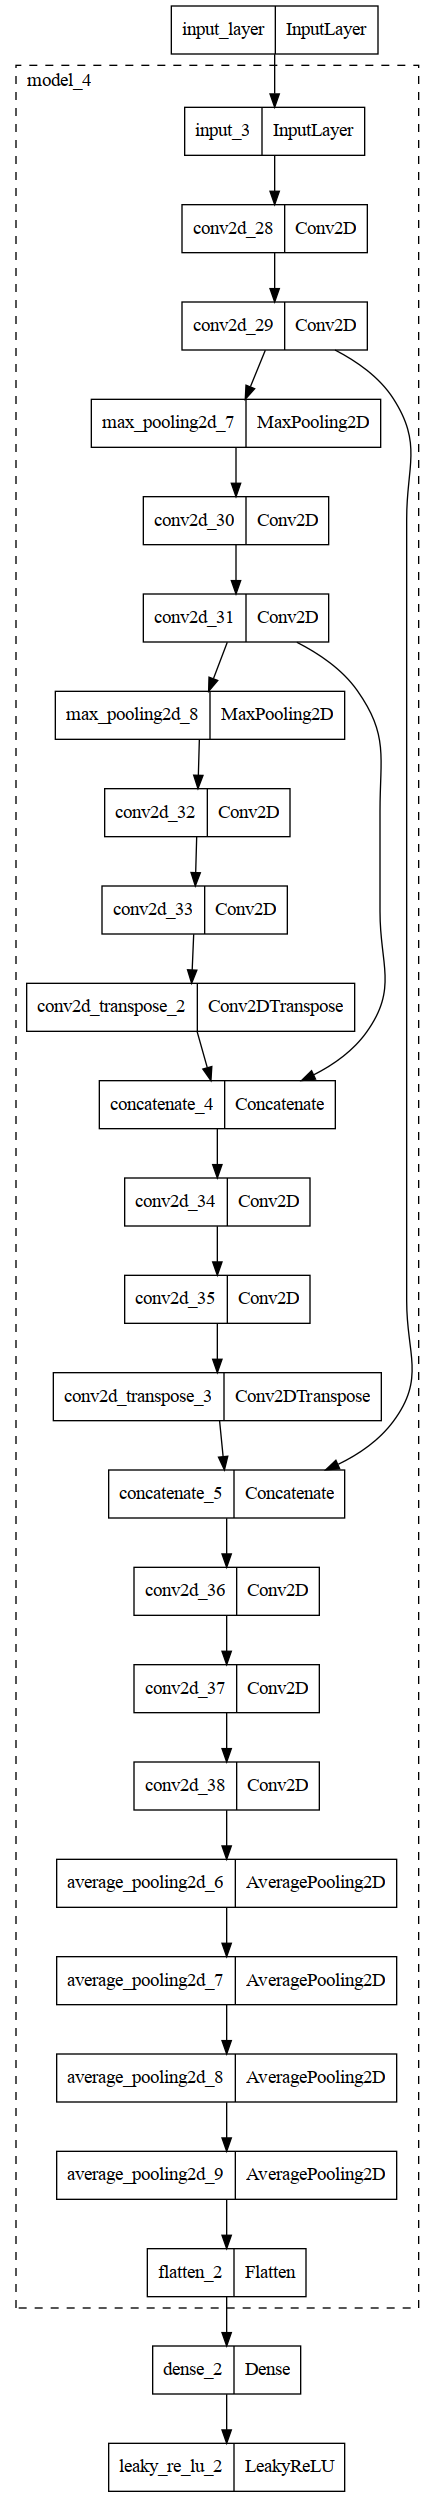

In [8]:
plot_model(model, expand_nested=True)

## ESSENTIAL

In [6]:
def essential_regressor(input_shape: list):
    """Essential regressor."""
    inputs = tf.keras.layers.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(32, (3, 3), activation="elu", strides=1)(inputs)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv2D(32, (3, 3), activation="elu", strides=1)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation="elu", strides=1)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation="elu", strides=1)(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation="elu", strides=1)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding="valid", strides=2)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation="elu", strides=1)(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation="elu", strides=1)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding="valid", strides=2)(x)
    x = tf.keras.layers.Flatten()(x)
    core_model = tf.keras.Model(inputs, x)
    return core_model

In [7]:
model = essential_regressor([32, 32, 3])

In [8]:
model.summary(expand_nested=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 dropout_8 (Dropout)         (None, 30, 30, 32)        0         
                                                                 
 batch_normalization_4 (Bat  (None, 30, 30, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 dropout_9 (Dropout)         (None, 28, 28, 32)        0         
                                                             

In [ ]:
reg_builder = rm.Reg_model_builder(name="essential")
model = reg_builder.get_model()
model.count_params()
model.summary(expand_nested=True)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 64, 64, 3)]       0         
                                                                 
 model_6 (Functional)        (None, 576)               185984    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_4 (InputLayer)       [(None, 64, 64, 3)]       0        |
|                                                               |
| conv2d_13 (Conv2D)         (None, 62, 62, 32)        896      |
|                                                               |
| dropout (Dropout)          (None, 62, 62, 32)        0        |
|                                                               |
| conv2d_14 (Conv2D)         (None, 60, 60, 32)        9248     |
|                                                               |
| max_pooling2d_2 (MaxPooli  (None, 30, 30, 32)        0   

## INCEPTION

In [3]:
reg_builder = rm.Reg_model_builder(name="inception_like_model")
model = reg_builder.get_model()
model.count_params()
model.summary(expand_nested=True)

2024-01-03 16:57:40.886671: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46863 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:3b:00.0, compute capability: 8.6
2024-01-03 16:57:40.887166: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46863 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:af:00.0, compute capability: 8.6


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 64, 64, 3)]       0         
                                                                 
 model (Functional)          (None, 128)               107584    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_1 (InputLayer)       [(None, 64, 64, 3)]       0        |
|                                                               |
| conv2d_3 (Conv2D)          (None, 64, 64, 16)        64       |
|                                                               |
| conv2d_5 (Conv2D)          (None, 64, 64, 16)        64       |
|                                                               |
| max_pooling2d_1 (MaxPooli  (None, 64, 64, 3)         0        |
| ng2D)                                                         |
|                                                          

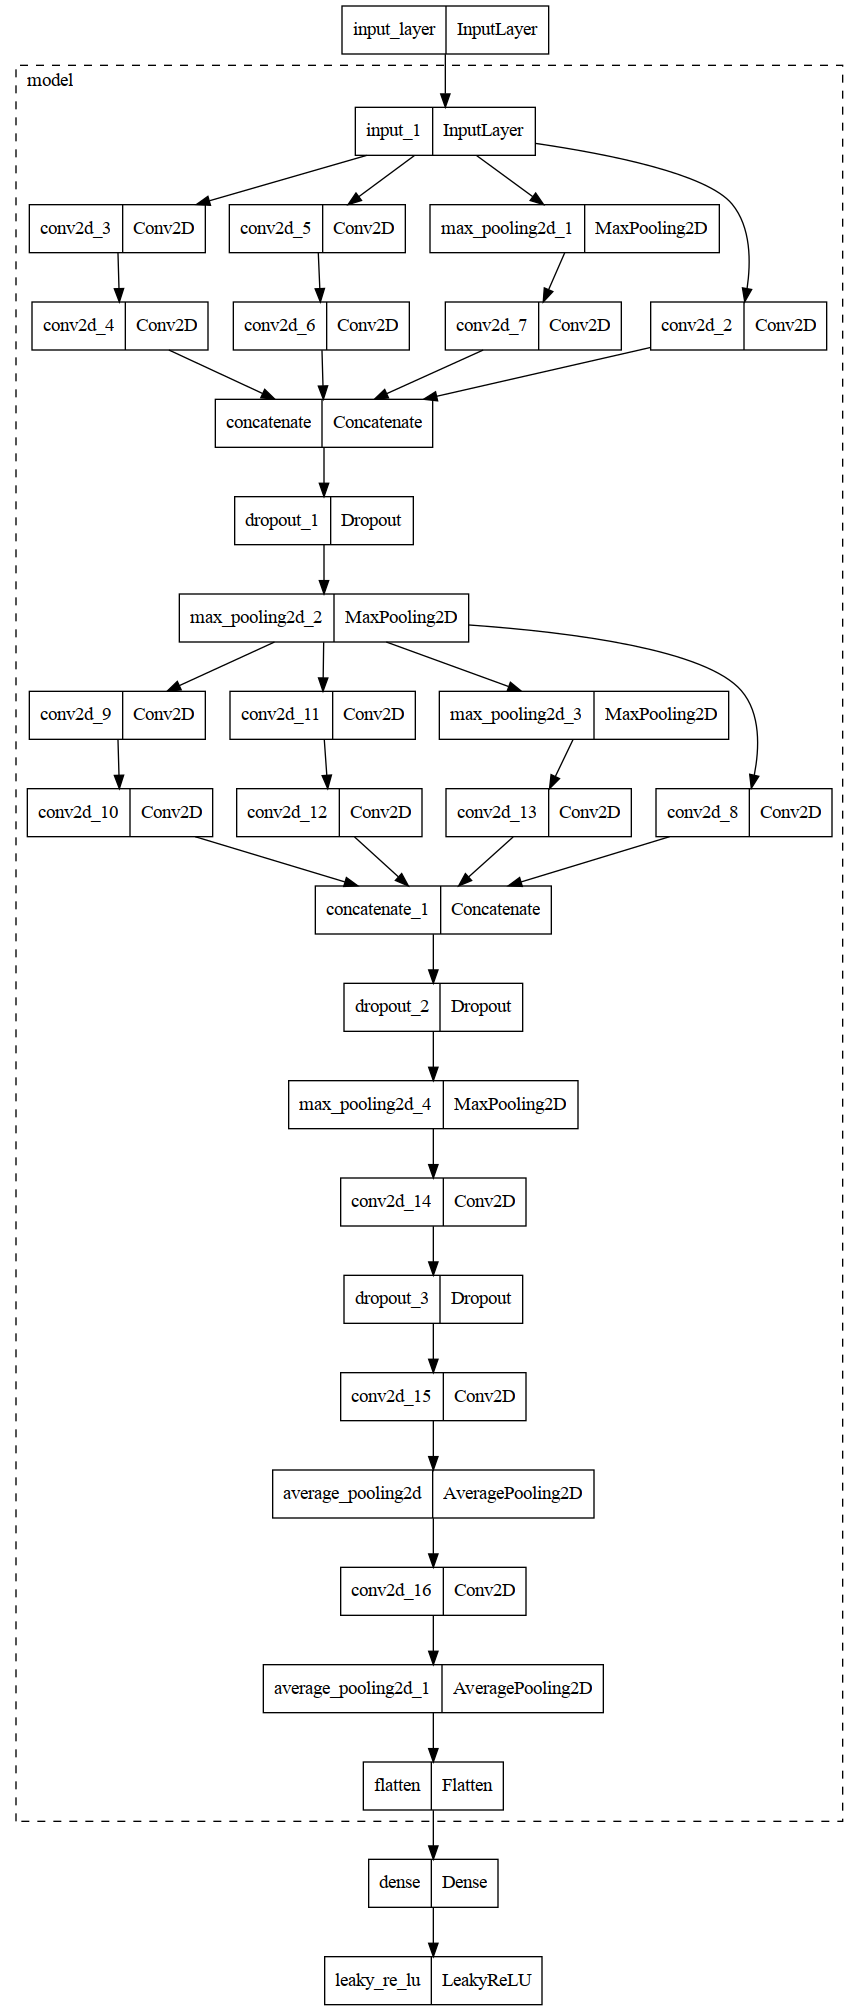

In [4]:
plot_model(model, expand_nested=True)

## ATTENTION

In [3]:
reg_builder = rm.Reg_model_builder(name="attention_cnn")
model = reg_builder.get_model()
model.count_params()
model.summary(expand_nested=True)

2024-01-03 16:55:56.470599: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46863 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:3b:00.0, compute capability: 8.6
2024-01-03 16:55:56.471066: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46863 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:af:00.0, compute capability: 8.6


ValueError: Inputs have incompatible shapes. Received shapes (15, 15, 32) and (15, 15, 64)

In [ ]:
plot_model(model,expand_nested=True)

## RESNET

In [3]:
reg_builder = rm.Reg_model_builder(name="simple_resnet")
model = reg_builder.get_model()
model.count_params()
model.summary(expand_nested=True)

Model: "model_1"
_________________________________________________________________


2024-01-03 16:53:08.338085: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46863 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:3b:00.0, compute capability: 8.6
2024-01-03 16:53:08.338644: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46863 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:af:00.0, compute capability: 8.6


 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 64, 64, 3)]       0         
                                                                 
 model (Functional)          (None, 3136)              113824    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_1 (InputLayer)       [(None, 64, 64, 3)]       0        |
|                                                               |
| conv2d (Conv2D)            (None, 62, 62, 32)        896      |
|                                                               |
| dropout (Dropout)          (None, 62, 62, 32)        0        |
|                                                               |
| conv2d_1 (Conv2D)          (None, 60, 60, 32)        9248     |
|                                                               |
| max_pooling2d (MaxPooling  (None, 30, 30, 32)        0        |
| 2D)                                                           |
|         

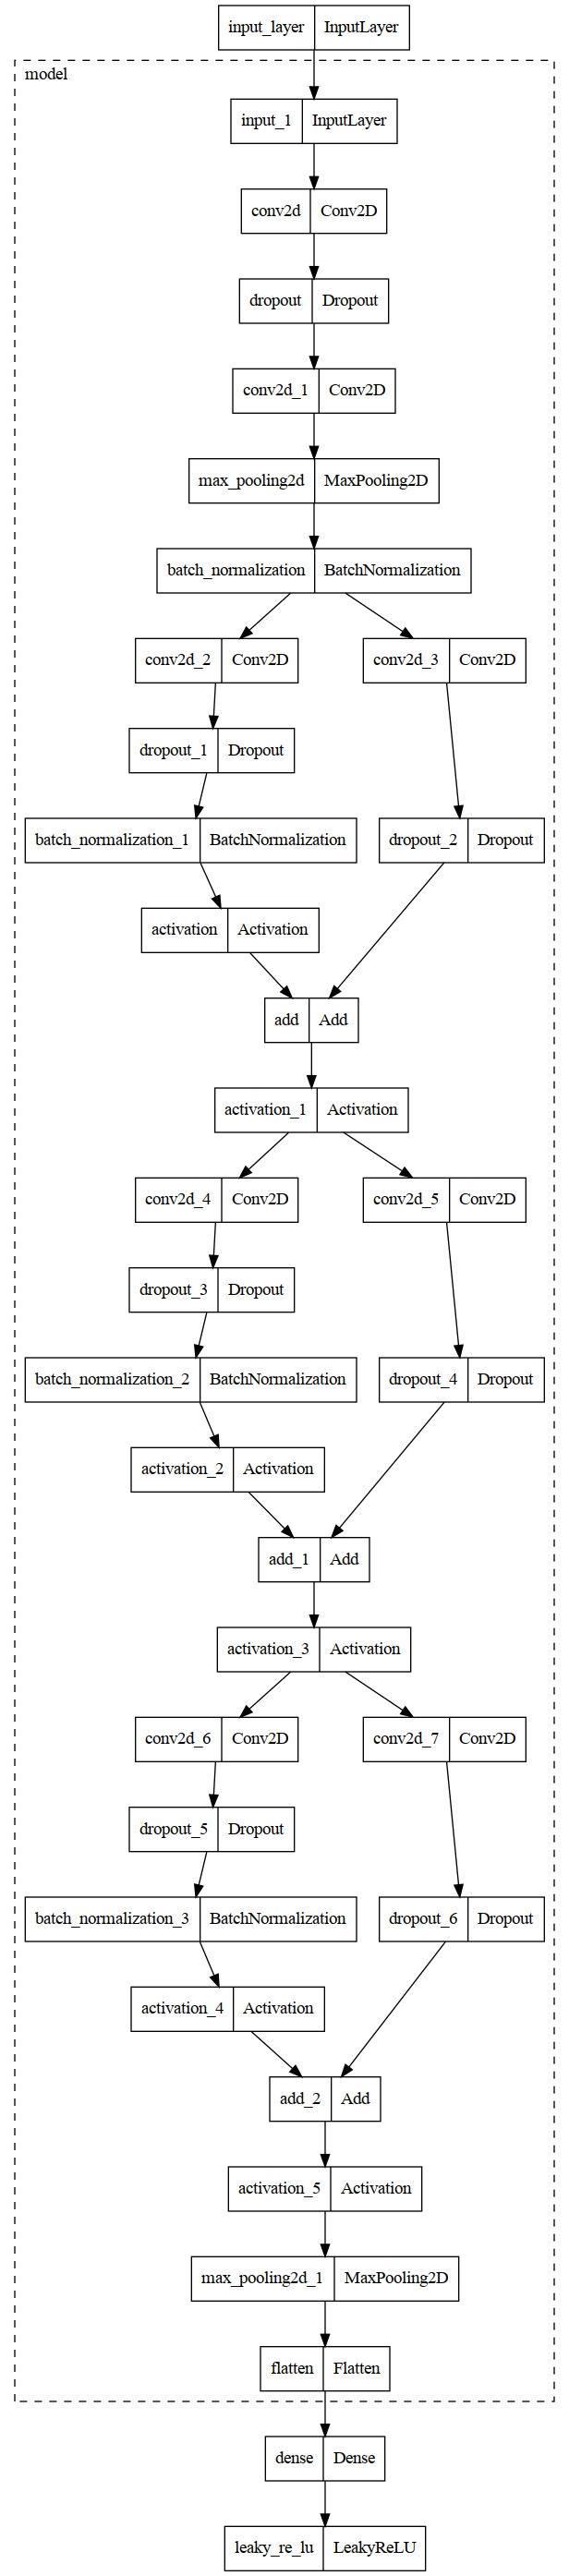

In [4]:
plot_model(model, expand_nested=True)

## DENSENET

In [5]:
reg_builder = rm.Reg_model_builder(name="densenet_like_model")
model = reg_builder.get_model()
model.count_params()
model.summary(expand_nested=True)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 64, 64, 3)]       0         
                                                                 
 model_2 (Functional)        (None, 256)               174442    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_2 (InputLayer)       [(None, 64, 64, 3)]       0        |
|                                                               |
| conv2d_14 (Conv2D)         (None, 32, 32, 32)        4736     |
|                                                               |
| batch_normalization_13 (B  (None, 32, 32, 32)        128      |
| atchNormalization)                                            |
|                                                               |
| activation_13 (Activation  (None, 32, 32, 32)        0        |
| )                                                        

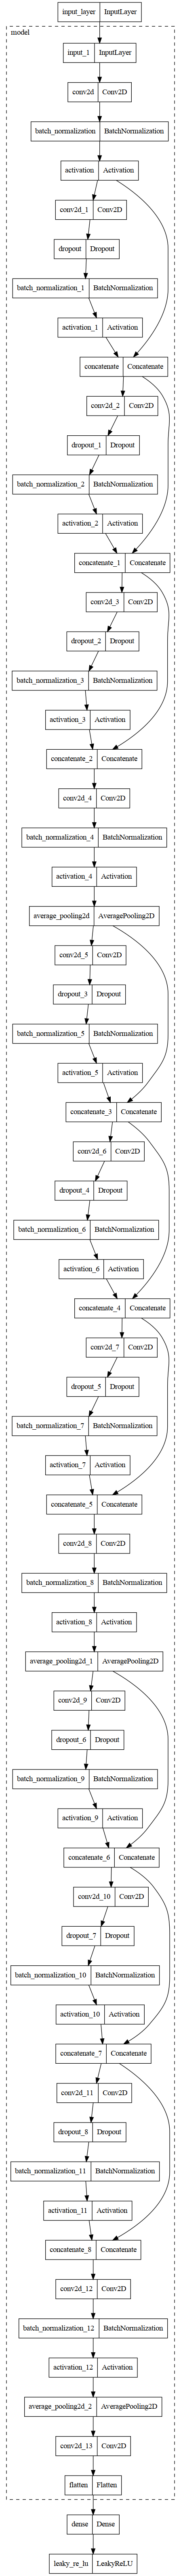

In [4]:
plot_model(model, expand_nested=True)

## DEEP CNN ADVANCED

In [15]:
reg_builder = rm.Reg_model_builder(name="deep_cnn_advanced")
model = reg_builder.get_model()
model.count_params()
model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 64, 64, 3)]       0         
                                                                 
 model_16 (Functional)       (None, 512)               287008    
                                                                 
 dense_8 (Dense)             (None, 1)                 513       
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 1)                 0         
                                                                 
Total params: 287521 (1.10 MB)
Trainable params: 287521 (1.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
reg_builder = rm.Reg_model_builder(name="squeezenet", scaling_coefficient=0.4)
model = reg_builder.get_model()
model.count_params()

109649

In [13]:
reg_builder = rm.Reg_model_builder(name="shufflenet", scaling_coefficient=0.75)
model = reg_builder.get_model()
model.count_params()

96265

In [14]:
reg_builder = rm.Reg_model_builder(name="mobilenet", scaling_coefficient=0.4)
model = reg_builder.get_model()
model.count_params()

84837

In [94]:
reg_builder = rm.Reg_model_builder(name="efficientnet", scaling_coefficient=0.5)
model = reg_builder.get_model()
model.count_params()

76434

In [4]:
model.summary(expand_nested=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 64, 64, 1)   0           ['input_layer[0][0]']            
 ingOpLambda)                                                                                     
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 64, 64, 1)   0           ['input_layer[0][0]']            
 icingOpLambda)                                                                                   
                                                                                            

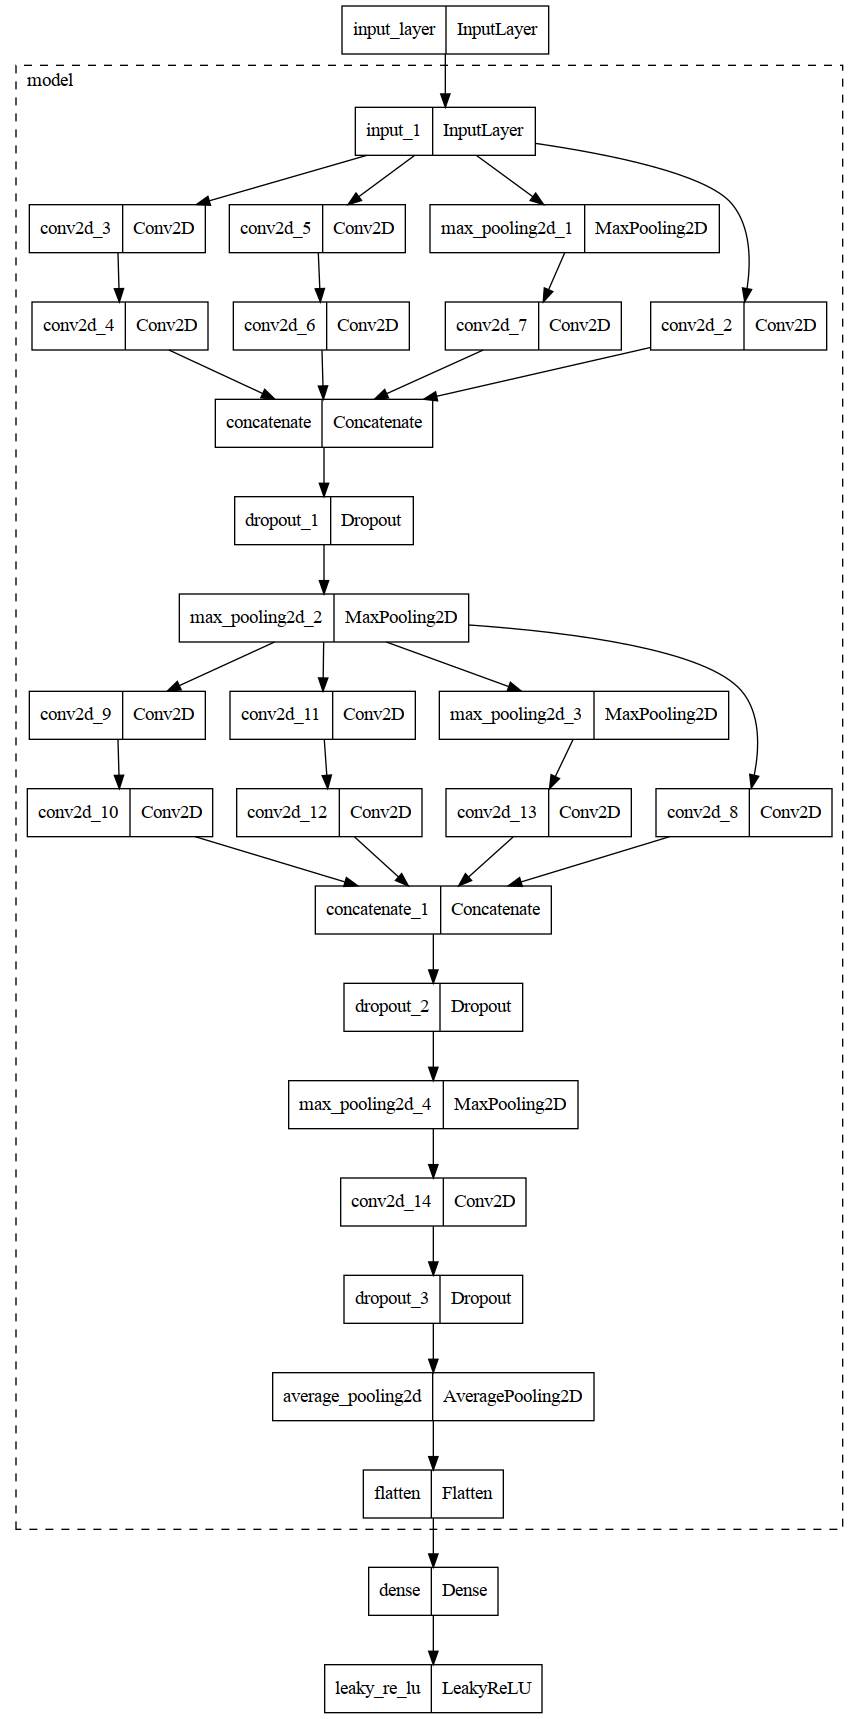

In [8]:
plot_model(model, expand_nested=True)

In [62]:
x=1

In [14]:
path_train_nc = "/libre/dumontj/coco2/dl-input/2km_forLip_2/train_dataset.nc"
path_valid_nc = "/libre/dumontj/coco2/dl-input/2km_forLip_2/valid_dataset.nc"
path_extra_valid_nc = "/libre/dumontj/coco2/dl-input/2km_Lip/valid_dataset.nc"

In [15]:
data = Data_train(path_train_nc, path_valid_nc, path_extra_valid_nc)
data.prepare_input("xco2")
data.prepare_output_inversion()

data.x.train.shape (25152, 64, 64, 1)


In [18]:
generator = ScaleDataGen(
    data.x.train, data.x.plumes_train, data.y.train, data.x.scale_bool, data.x.fields_input_shape
)

In [19]:
reg_builder = rm.Reg_model_builder(
    "squeezenet",
    data.x.fields_input_shape,
    data.y.classes,
    data.x.n_layer,
    data.x.xco2_noisy_chans,
)
model = reg_builder.get_model()
model.compile("adam", "MeanAbsoluteError")
model.fit(generator_flowing, epochs=15, validation_data=(data.x.valid, data.y.valid))

Epoch 1/15


2023-03-06 14:06:40.781033: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/model_6/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


681/786 [========================>.....] - ETA: 1s - loss: 5.8763

KeyboardInterrupt: 

In [9]:
model.fit(generator_flowing, epochs=15, validation_data=(data.x.valid, data.y.valid))

Epoch 1/15
786/786 [==============================] - 12s 15ms/step - loss: 2.3062 - val_loss: 2.7255
Epoch 2/15
786/786 [==============================] - 11s 14ms/step - loss: 2.3199 - val_loss: 2.5573
Epoch 3/15
786/786 [==============================] - 11s 15ms/step - loss: 2.2709 - val_loss: 2.6424
Epoch 4/15
786/786 [==============================] - 12s 15ms/step - loss: 2.2774 - val_loss: 2.4683
Epoch 5/15
786/786 [==============================] - 12s 16ms/step - loss: 2.2790 - val_loss: 2.5814
Epoch 6/15
786/786 [==============================] - 11s 14ms/step - loss: 2.2703 - val_loss: 2.5801
Epoch 7/15
786/786 [==============================] - 11s 14ms/step - loss: 2.2709 - val_loss: 2.3629
Epoch 8/15
786/786 [==============================] - 11s 15ms/step - loss: 2.2519 - val_loss: 2.5180
Epoch 9/15
786/786 [==============================] - 11s 15ms/step - loss: 2.2269 - val_loss: 2.5006
Epoch 10/15
786/786 [==============================] - 11s 15ms/step - loss: 2.222

In [10]:
model.fit(generator_flowing, epochs=15, validation_data = (data.x.extra_valid, data.y.extra_valid))

Epoch 1/15
786/786 [==============================] - 12s 15ms/step - loss: 2.5581 - val_loss: 2.8079
Epoch 2/15
786/786 [==============================] - 12s 15ms/step - loss: 2.5644 - val_loss: 2.7652
Epoch 3/15
786/786 [==============================] - 11s 15ms/step - loss: 2.5420 - val_loss: 2.6070
Epoch 4/15
786/786 [==============================] - 12s 15ms/step - loss: 2.5304 - val_loss: 2.6831
Epoch 5/15
786/786 [==============================] - 12s 15ms/step - loss: 2.5152 - val_loss: 2.6791
Epoch 6/15
786/786 [==============================] - 12s 15ms/step - loss: 2.4592 - val_loss: 2.5438
Epoch 7/15
786/786 [==============================] - 12s 15ms/step - loss: 2.4526 - val_loss: 2.9053
Epoch 8/15
786/786 [==============================] - 11s 15ms/step - loss: 2.4504 - val_loss: 2.8075
Epoch 9/15
786/786 [==============================] - 12s 15ms/step - loss: 2.4294 - val_loss: 2.4807
Epoch 10/15
786/786 [==============================] - 11s 15ms/step - loss: 2.399

In [78]:
generator.on_epoch_end()
x,y = generator.__getitem__(0)

[12530  2585  5524 14873  8906 23832 19486 19723 14656 23348 13816 20133
  5717  6680 24675 21749 17771  3636 24164  7299 20789 16896 13033 17217
  8563 13971 17313 23138  2587 20512  8727 10725]
[ 2.51706641  2.79852553 -0.17406887 -0.09315784 -0.33088692  0.58131834
  0.77291584  0.57350458  0.14036729  2.00660195  1.02793089  1.51527305
  1.28742844  2.75948171  0.342553    2.11565735  0.06228612  0.53682995
  1.24814754  0.70002774  1.58599958  0.6435116   1.71808904  0.60771648
 -0.18912062  2.34212497  0.89834478 -0.20611053 -0.14301071  0.08413031
  2.38146377 -0.17438681]


In [79]:
idx = 0
idx_data = 12530
increase = 2.51706641

In [94]:
((scaling_coeff-1)*data.x.plumes_train[idx_data, :,:,3])

TypeError: unhashable type: 'slice'

3.517066412631618


/tmp/ipykernel_2233982/2708005084.py:21: RuntimeWarning: invalid value encountered in divide
  plt.imshow((xco2_prec_gen - xco2_prec_hand)/((scaling_coeff-1)*data.x.plumes_train[3][idx_data, :,:,0]))


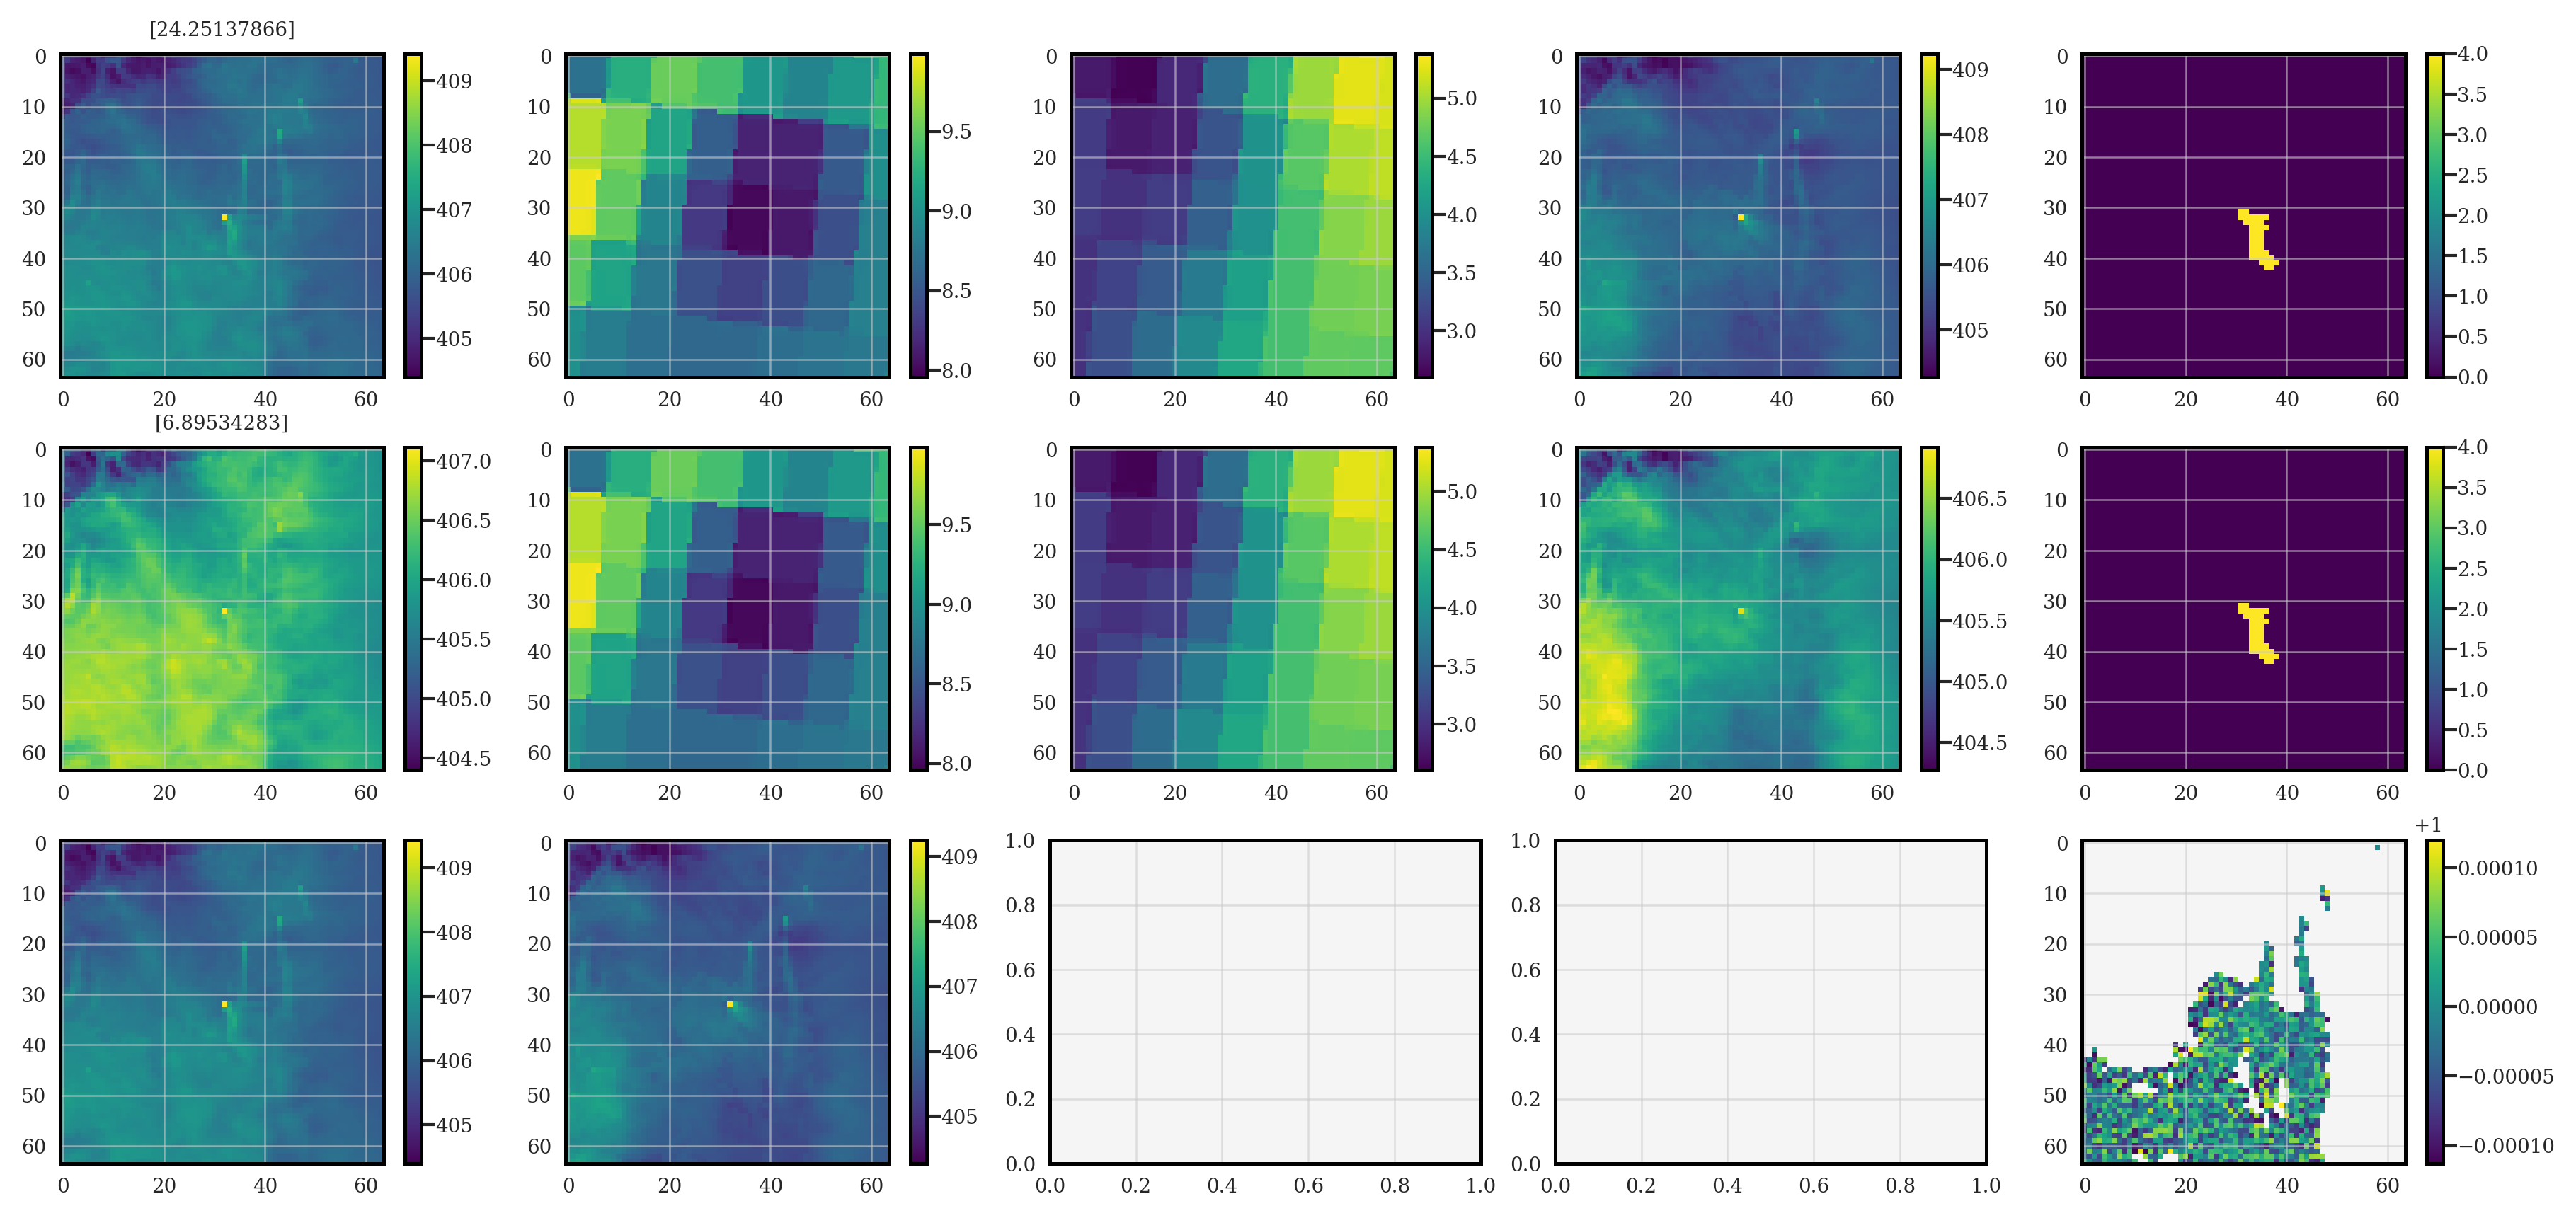

In [95]:
scaling_coeff = y[idx][0] / data.y.train[idx_data][0]
print(scaling_coeff)
N_cols = 5
axs = mympf.set_figure_axs(3,N_cols)
for col, ax in enumerate(axs[:N_cols]):
    im = ax.imshow(np.squeeze(x[idx, :,:,col]))
    plt.colorbar(im)
axs[0].set_title(f"{y[idx]}")
for col, ax in enumerate(axs[N_cols:N_cols*2]):
    im = ax.imshow(np.squeeze(data.x.train[idx_data, :,:,col]))
    plt.colorbar(im)
axs[N_cols].set_title(f"{data.y.train[idx_data]}")

im = axs[N_cols*2].imshow(np.squeeze(data.x.train[idx_data, :,:,0]) + (scaling_coeff-1)*np.squeeze(data.x.plumes_train[0][idx_data]))
plt.colorbar(im)    
im = axs[N_cols*2+1].imshow(np.squeeze(data.x.train[idx_data, :,:,3]) + (scaling_coeff-1)*np.squeeze(data.x.plumes_train[3][idx_data]))
plt.colorbar(im)

xco2_prec_hand = np.squeeze(data.x.train[idx_data, :,:,3])
xco2_prec_gen = np.squeeze(x[idx, :,:,3])
plt.imshow((xco2_prec_gen - xco2_prec_hand)/((scaling_coeff-1)*data.x.plumes_train[3][idx_data, :,:,0]))
plt.colorbar()

In [109]:
generator.x.shape

(25152, 64, 64, 1)

In [110]:
x, y = generator.__getitem__(0)

In [23]:
uni_scaling = np.random.uniform(-0.5, 3, size=(32, 1, 1, 1))
x_batch = self.x[batches] + uni_scaling * data.plume[batches]
y_batch = self.y[batches] + np.squeeze(uni_scaling) * self.y[batches]

1

In [89]:
uni_scaling = np.random.uniform(-0.5, 3, size=(batch_size))  # , size=(self.batch_size, 1, 1, 1))

In [87]:
uni_scaling.shape

(32,)

In [93]:
np.expand_dims(uni_scaling, (1,1))

ValueError: repeated axis

In [96]:
uni_scaling.reshape(uni_scaling.shape + (1,) * 2).shape

(32, 1, 1)

In [103]:
(1,) * 2

(1, 1)

In [123]:
a = {1: [1, 2], 2: [2, 3]}

In [124]:
a[1]

[1, 2]

In [121]:
"prec" in "xco2_prec"

True

In [16]:
import random
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image


def add_noise(img, img_2=None):
    """Add random noise to an image"""
    VARIABILITY = 50
    deviation = VARIABILITY * random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0.0, 255.0)
    return img


datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    preprocessing_function=add_noise,
)


img_path = "/cerea_raid/users/dumontj/elephant.jpg"
img = image.load_img(img_path, target_size=(299, 299))

# Generate distorted images
images = [img]
img_arr = image.img_to_array(img)
img_arr = img_arr.reshape((1,) + img_arr.shape)
for batch in datagen.flow((img_arr, img_arr), batch_size=1):
    images.append(image.array_to_img(batch[0]))
    if len(images) >= 4:
        break

# Display
import matplotlib.pyplot as plt

f, xyarr = plt.subplots(2, 2)
xyarr[0, 0].imshow(images[0])
xyarr[0, 1].imshow(images[1])
xyarr[1, 0].imshow(images[2])
xyarr[1, 1].imshow(images[3])
plt.show()

ValueError: Expected image array to have rank 3 (single image). Got array with shape: (1, 299, 299, 3)

In [ ]:
                
                tf.math.multiply(
                    uniformNoiseLayer(minval=1, maxval=4)(
                        tf.ones([x.shape[0], 1, 1, 1]), name=f"uniform_{idx}"
                    ),
                    z[int(chans_to_scale[idx])],


In [139]:
class uniformNoiseLayer(tf.keras.layers.Layer):
    def __init__(self, minval, maxval):
        super(uniformNoiseLayer, self).__init__()
        self.minval = minval
        self.maxval = maxval

    def call(self, input):

        minval = self.minval
        maxval = self.maxval
        random_uni = tf.random.uniform(
            tf.shape(input[:, 0, 0, 0]), minval=minval, maxval=maxval
        )
        random_uni = tf.expand_dims(random_uni, -1)
        random_uni = tf.expand_dims(random_uni, -1)
        random_uni = tf.expand_dims(random_uni, -1)

        return input * random_uni


X = tf.ones([10, 16, 16, 1])
Y = uniformNoiseLayer(minval=1, maxval=4)(X)
print(Y.shape)

(10, 16, 16, 1)


In [158]:
N_data = 100
data_x = np.random.normal(size=(N_data, 64, 64, 6))
plume_x = np.random.normal(size=(N_data, 64, 64, 6))
data_y = np.random.normal(size=(N_data, 1))

In [230]:
def get_preprocessing_layers(
    n_layer: tf.keras.layers.Normalization,
    n_chans: int,
    noisy_chans: list,
    chans_to_scale: list,
    N_data: int,
):
    """Return preprocessing layers for regression model."""

    def get_scale_layers(x, z):
        chans_for_scale = [None] * n_chans
        for idx in range(n_chans):
            if chans_to_scale[idx] != -1:
                chans_for_scale[idx] = x[:, :, :, idx : idx + 1] + uniformNoiseLayer(
                    minval=1, maxval=4
                )(z[:, :, :, idx : idx + 1])
            else:
                chans_for_scale[idx] = tf.keras.layers.Layer()(
                    x[:, :, :, idx : idx + 1], name=f"unipass_{idx}"
                )
        x = tf.keras.layers.Concatenate()(chans_for_scale)
        return x

    def get_noise_layers(x):
        chans = [None] * n_chans
        for idx in range(n_chans):
            if noisy_chans[idx]:
                chans[idx] = tf.keras.layers.GaussianNoise(
                    stddev=0.7, name=f"noise_{idx}"
                )(x[:, :, :, idx : idx + 1])
            else:
                chans[idx] = tf.keras.layers.Layer()(
                    x[:, :, :, idx : idx + 1], name=f"noisypass_{idx}"
                )

        concatted = tf.keras.layers.Concatenate()(chans)
        return concatted

    def preproc_layers(x, z):

        x = get_scale_layers(x, z)
        # x = tf.keras.layers.Add()([x, z])
        print("after scale", x.shape)

        x = get_noise_layers(x)
        print("after noise", x.shape)

        x = n_layer(x)
        print("after norm", x.shape)

        return x

    return preproc_layers

In [224]:
input1 = tf.keras.layers.Input(shape=(16,))
x1 = tf.keras.layers.Dense(8, activation="relu")(input1)
input2 = tf.keras.layers.Input(shape=(32,))
x2 = tf.keras.layers.Dense(8, activation="relu")(input2)
added = tf.keras.layers.Add()([x1, x2])
out = tf.keras.layers.Dense(4)(added)
model = tf.keras.models.Model(inputs=[input1, input2], outputs=out)

In [237]:
from models.reg import get_top_layers, get_core_model

top_layers = get_top_layers(1, "essential")
bottom_layers = get_preprocessing_layers(
    tf.keras.layers.Normalization(),
    data_x.shape[-1],
    [True, False, False, True, False, False],
    [0, -1, -1, 0, -1, -1],
    data_x.shape[0],
)
core_model = get_core_model("essential", data_x.shape[1:], 1)

In [240]:
inputs = tf.keras.layers.Input(data_x.shape[1:])
plume_inputs = tf.keras.layers.Input(data_x.shape[1:])
x = bottom_layers(inputs, plume_inputs)
x = core_model(x)
outputs = top_layers(x)

model = tf.keras.Model([inputs, plume_inputs], outputs)
model.compile(loss="MeanAbsoluteError", optimizer="adam")

after scale (None, 64, 64, 6)
after noise (None, 64, 64, 6)
after norm (None, 64, 64, 6)


In [239]:
input1 = tf.keras.layers.Input(shape=(16,))
input2 = tf.keras.layers.Input(shape=(32,))
added = tf.keras.layers.Add()([input1, input1])
model = tf.keras.models.Model(inputs=[input1, input2], outputs=added)

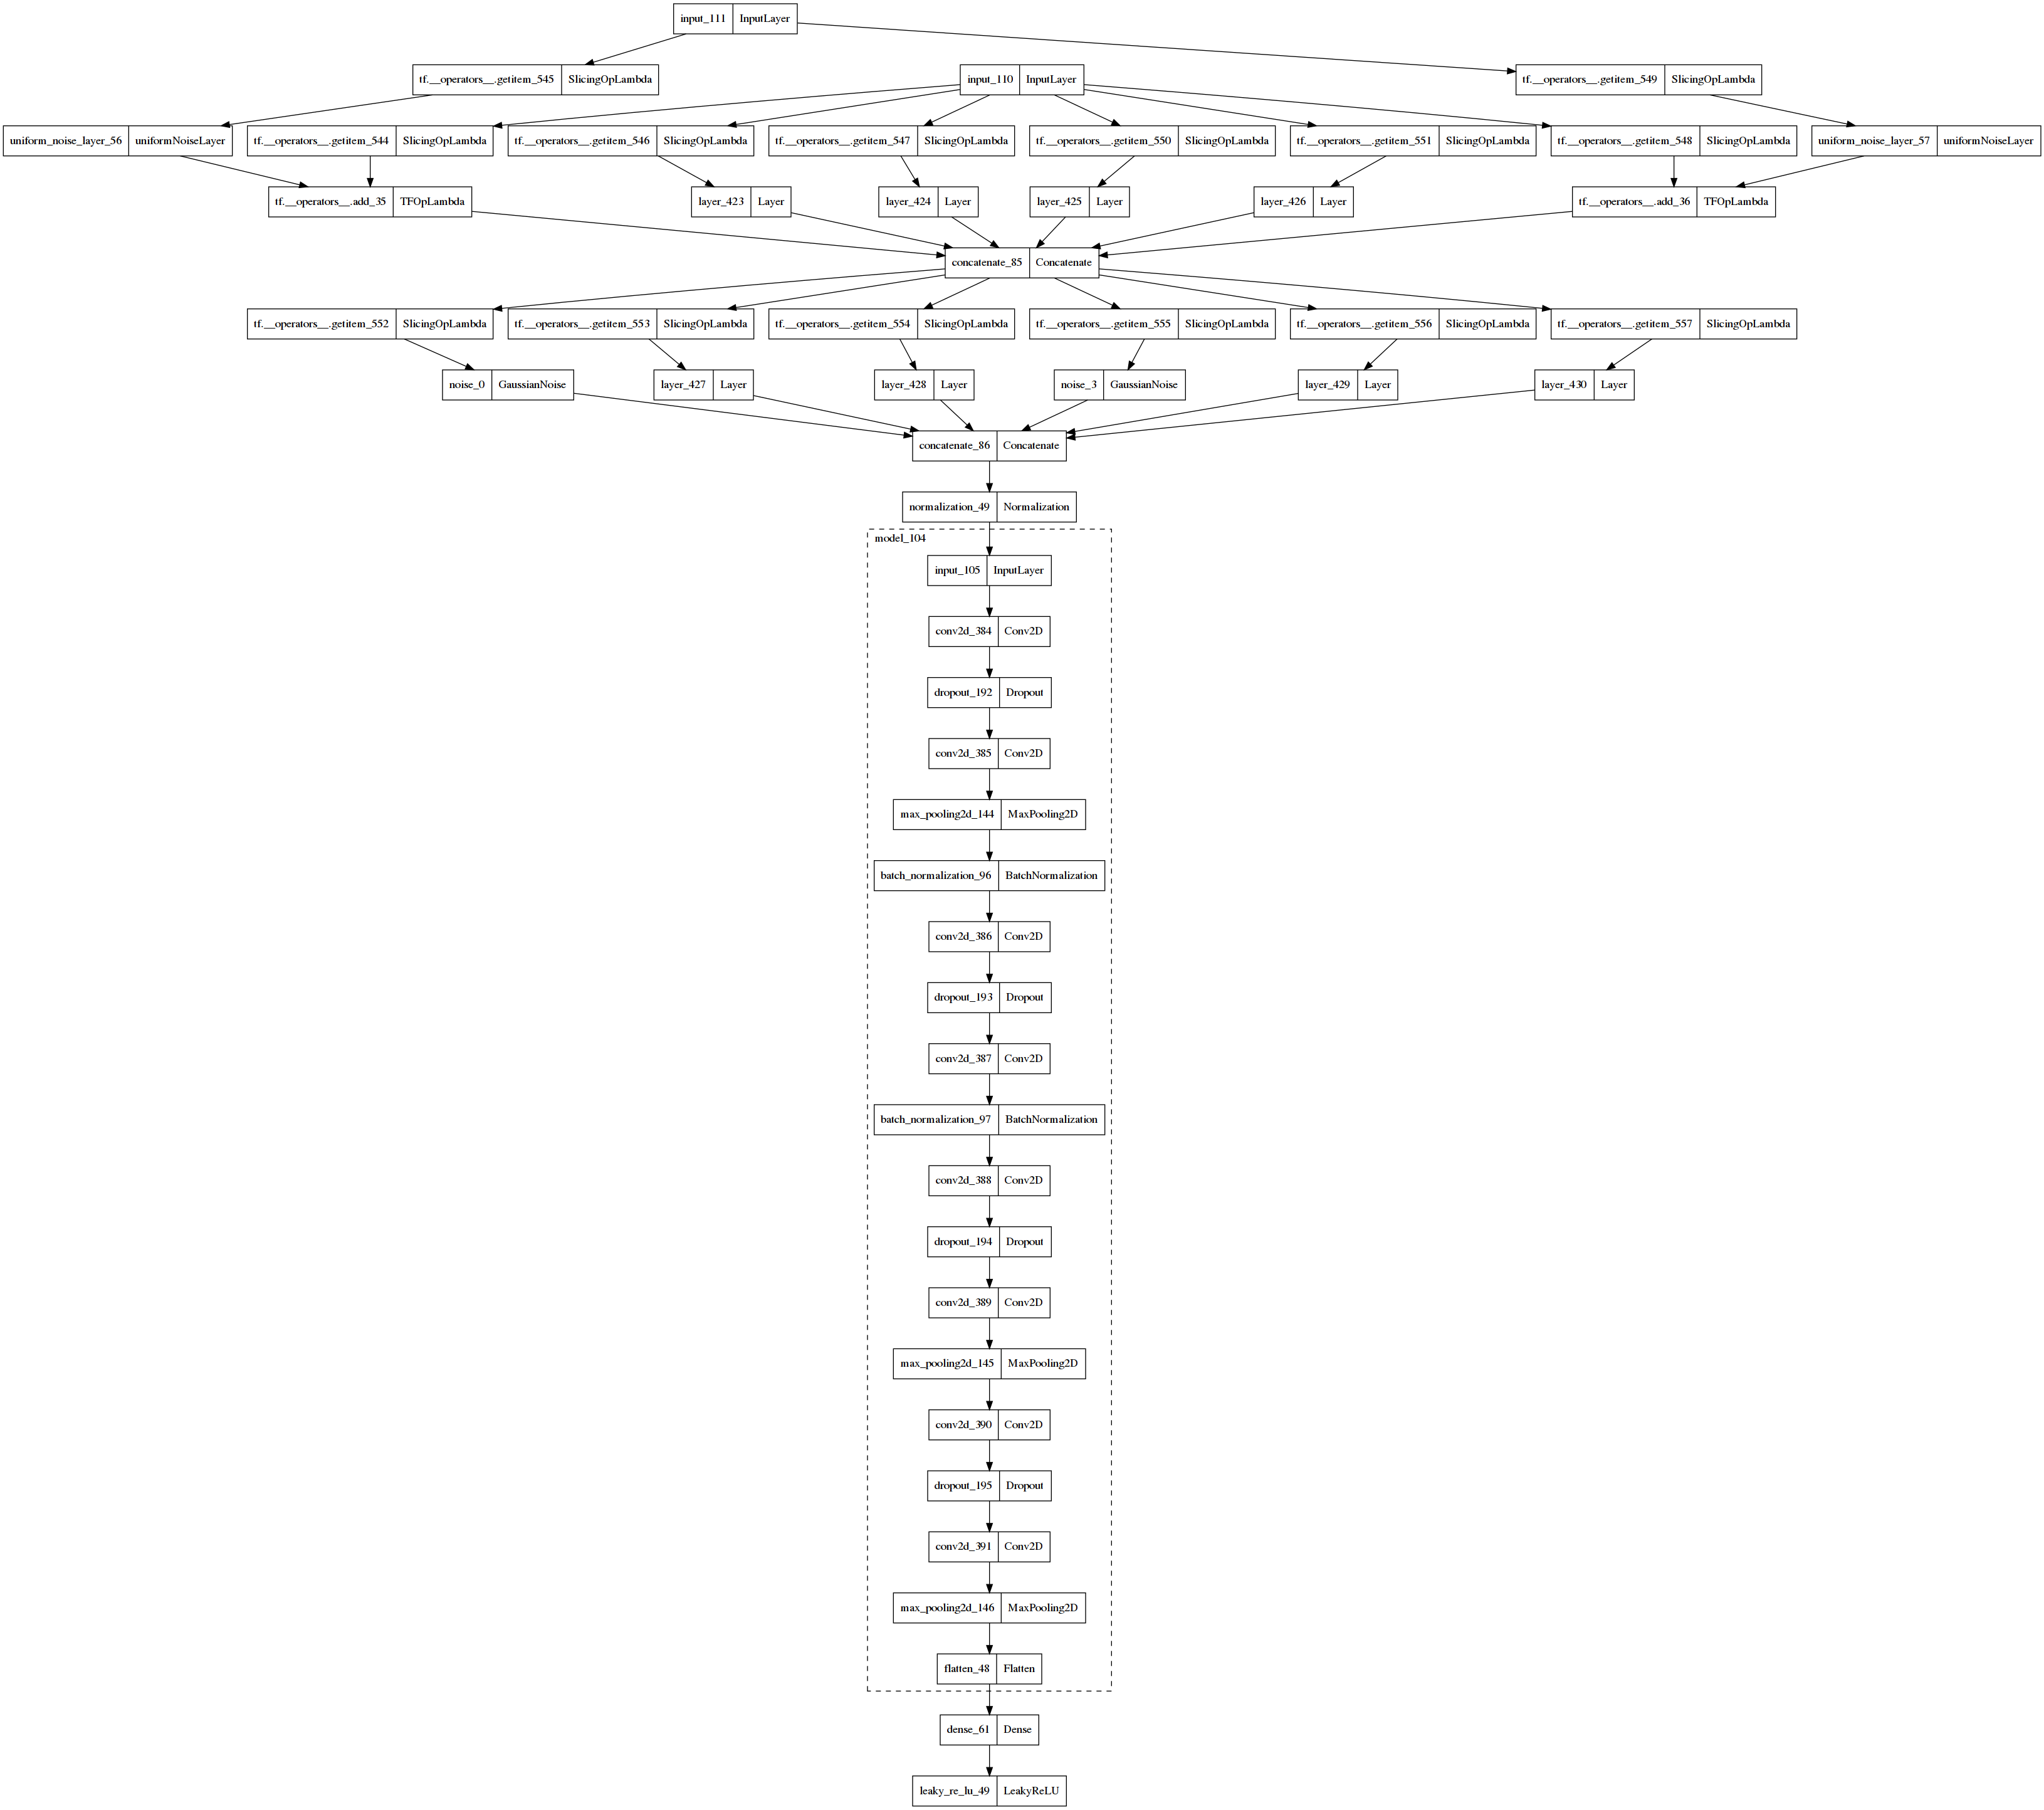

In [241]:
plot_model(model, expand_nested=True)

In [78]:
uni.shape[0]

1000

In [72]:
z = plume_x
z.shape

(1000, 64, 64, 1)

In [73]:
tf.math.multiply(uni, z)

<tf.Tensor: shape=(1000, 64, 64, 1), dtype=float32, numpy=
array([[[[-2.9193707 ],
         [-6.071825  ],
         [-0.8127686 ],
         ...,
         [-2.1425397 ],
         [ 0.80426335],
         [-0.20856014]],

        [[ 2.012096  ],
         [ 1.7918972 ],
         [ 1.105064  ],
         ...,
         [-5.9241004 ],
         [ 0.4708562 ],
         [-0.592771  ]],

        [[ 9.0332365 ],
         [-2.6590912 ],
         [-2.0934715 ],
         ...,
         [ 3.2822638 ],
         [-0.25774232],
         [-1.6369637 ]],

        ...,

        [[ 1.8209664 ],
         [ 2.5896294 ],
         [ 0.65146065],
         ...,
         [ 2.324451  ],
         [ 2.5308788 ],
         [-7.9846497 ]],

        [[ 6.0109572 ],
         [-0.34069183],
         [-1.5786337 ],
         ...,
         [ 2.815444  ],
         [ 0.63062936],
         [ 4.8470316 ]],

        [[ 3.4615088 ],
         [ 5.217311  ],
         [-6.4883823 ],
         ...,
         [-1.6312343 ],
         [ 2.8698

In [30]:
inputs = tf.keras.layers.Input(data_x.shape[1:], name="input_layer")
x = bottom_layers(inputs)
x = core_model(x)
outputs = top_layers(x)

model = tf.keras.Model(inputs, outputs)

In [56]:
class uniformNoiseLayer(tf.keras.layers.Layer):
    def __init__(self, minval, maxval):
        super(uniformNoiseLayer, self).__init__()
        self.minval = minval
        self.maxval = maxval

    def call(self, input):

        minval = self.minval
        maxval = self.maxval

        return input * tf.random.uniform(
            tf.shape(input).numpy(), minval=minval, maxval=maxval
        )


X = tf.ones([10])
Y = uniformNoiseLayer(minval=1, maxval=4)(X)

In [57]:
Y

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([1.3871164, 3.785771 , 3.107666 , 2.5772223, 1.316884 , 2.6170392,
       2.8591232, 2.4075527, 2.7144613, 1.7839417], dtype=float32)>

In [ ]:
plt.imshow

In [36]:
from models.alt_efficientnet import EfficientNetB0


def get_bottom_layers(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)
    outputs = n_layer(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_bottom_noisy(x_train):
    first_layer = tf.keras.layers.Layer()(x_train)
    x1 = tf.keras.layers.GaussianNoise(stddev=0.7)(
        first_layer[:, :, :, 0:1], training=True
    )
    x2 = tf.keras.layers.Layer()(first_layer[:, :, :, 1:])
    concatted = tf.keras.layers.Concatenate()([x1, x2])
    output = n_layer(concatted)
    return output

In [230]:
def bottom(n_layer, input_shape):
    def bottom_layers(x):
        x = n_layer(x)
        return x

    return bottom_layers


def top(classes):
    def top_layers(x):
        x = tf.keras.layers.GlobalAveragePooling2D(name="pooling_layer")(x)
        x = tf.keras.layers.Dense(classes, name="output_layer")(x)
        outputs = tf.keras.layers.LeakyReLU(
            alpha=0.3, dtype=tf.float32, name="activation_layer"
        )(x)
        return outputs

    return top_layers

In [247]:
def get_reg_model(input_shape, classes, base_model, n_layer):
    """Add top layers to regression model."""
    bottom_layers = bottom(n_layer, input_shape)
    top_layers = top(classes)

    inputs = tf.keras.layers.Input(input_shape, name="input_layer")
    x = bottom_layers(inputs)
    x = base_model(x)
    outputs = top_layers(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [251]:
def add_bottom_top(input_shape, classes, base_model, n_layer):
    """Add top layers to regression model."""
    bottom_layers = bottom(n_layer, input_shape)
    top_layers = top(classes)

    inputs = tf.keras.layers.Input(input_shape, name="input_layer")
    x = bottom_layers(inputs)
    x = base_model(x)
    outputs = top_layers(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [254]:
model = get_reg_model(
    data.x.fields_input_shape,
    1,
    EfficientNetB0(input_shape=data.x.fields_input_shape),
    n_layer,
)

In [207]:
inputs = tf.keras.layers.Input(shape=data.x.fields_input_shape)
x = n_layer(inputs)
outputs = EfficientNetB0(input_shape=data.x.fields_input_shape)(x)

/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras_applications/imagenet_utils.py:276: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 2 input channels.
  warnings.warn(


In [209]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [211]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 64, 64, 2)]       0         
                                                                 
 normalization_4 (Normalizat  (None, 64, 64, 2)        5         
 ion)                                                            
                                                                 
 efficientnetb0 (Functional)  (None, 2, 2, 1280)       4049276   
                                                                 
Total params: 4,049,281
Trainable params: 4,007,260
Non-trainable params: 42,021
_________________________________________________________________


In [190]:
base_model = EfficientNetB0()

In [205]:
bottom_model

In [200]:
base_model

In [204]:
bottom_model = get_bottom_layers(data.x.fields_input_shape)

In [53]:
model.save("to_delete.h5")

In [56]:
model = tf.keras.models.load_model("to_delete.h5")

In [ ]:
full_model = tf.keras.Model(inputs = 

In [43]:
n_layer = tf.keras.layers.Normalization(axis=-1)
n_layer.adapt(data.x.train)

In [48]:
n_layer(data.x.train).numpy()[:, :, :, 1].var()

1.0000002

In [50]:
model = get_model(n_layer, data.x.fields_input_shape)

In [224]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=45,
    zoom_range=0.2,
)
image_generator = generator.flow(
    data.x.train, seed=27, batch_size=data.x.train.shape[0], shuffle=True
)
gen_x_train = image_generator.next()

/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/preprocessing/image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (2304, 64, 64, 2) (2 channels).
  warnings.warn(


In [160]:
def get_output_noisy(x_train):
    first_layer = tf.keras.layers.Layer()(x_train)
    x1 = tf.keras.layers.GaussianNoise(stddev=0.7)(
        first_layer[:, :, :, 0:1], training=True
    )
    x2 = tf.keras.layers.Layer()(first_layer[:, :, :, 1:])
    concatted = tf.keras.layers.Concatenate()([x1, x2])
    output = n_layer(concatted)
    return output


def get_output_noiseless(x_train):
    first_layer = tf.keras.layers.Layer()(x_train)
    x1 = tf.keras.layers.Layer()(first_layer[:, :, :, 0:1], training=True)
    x2 = tf.keras.layers.Layer()(first_layer[:, :, :, 1:])
    concatted = tf.keras.layers.Concatenate()([x1, x2])
    output = n_layer(concatted)
    return output

In [155]:
output_noisy = get_output_noisy(data.x.train)
output_noiseless = get_output_noiseless(data.x.train)

In [172]:
output_noisy = get_output_noisy(gen_x_train)
output_noiseless = get_output_noiseless(gen_x_train)

In [187]:
idx = np.random.choice(range(1000))

# OLD

In [9]:
eval_shuffler = Eval_Shuffler(
    "/libre/dumontj/coco2/dl-input/2km_forBer/2d_train_dataset.nc",
    "/libre/dumontj/coco2/dl-input/2km_Ber/2d_valid_dataset.nc",
)

data = Data_train(
    eval_shuffler,
    "/libre/dumontj/coco2/dl-input/2km_forBer/2d_train_dataset.nc",
    "/libre/dumontj/coco2/dl-input/2km_Ber/2d_valid_dataset.nc",
)

data.prepare_input(
    "xco2",
    "no2",
    dir_seg_models="/cerea_raid/users/dumontj/dev/coco2/dl/res/models",
)
data.prepare_output_segmentation()

data.x.train.shape (37734, 64, 64, 2)
data.y.train.shape (37734, 64, 64, 1)


In [11]:
model = build_model(
    "segmentation",
    "Unet_efficientnetb0",
    data.x.fields_input_shape,
    data.y.classes,
    0.2,
)
model.compile(
    optimizer=optimisers.define_optimiser(),
    loss=loss.define_loss("pixel_weighted_cross_entropy"),
)

EfficientNetB0 [64, 64, 2] 1


/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/applications/efficientnet.py:321: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 2 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
2023-01-19 17:41:02.297505: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 17:41:02.815188: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14537 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 64, 64, 2)    0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 64, 64, 2)    5           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 65, 65, 2)    0           ['normalization[0][0]']          
                                                                                              

In [12]:
seed = 27

In [35]:
data_gen_args = dict(
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=False,
    vertical_flip=False,
    shear_range=0,
    zoom_range=0,
)

image_datagen = keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
mask_datagen = keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
image_generator = image_datagen.flow(data.x.train, seed=seed, batch_size=32)
mask_generator = mask_datagen.flow(data.y.train, seed=seed, batch_size=32)

train_generator = zip(image_generator, mask_generator)

/profils_cerea/dumontj/mambaforge/envs/gpu/lib/python3.9/site-packages/keras/preprocessing/image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (37734, 64, 64, 2) (2 channels).
  warnings.warn(


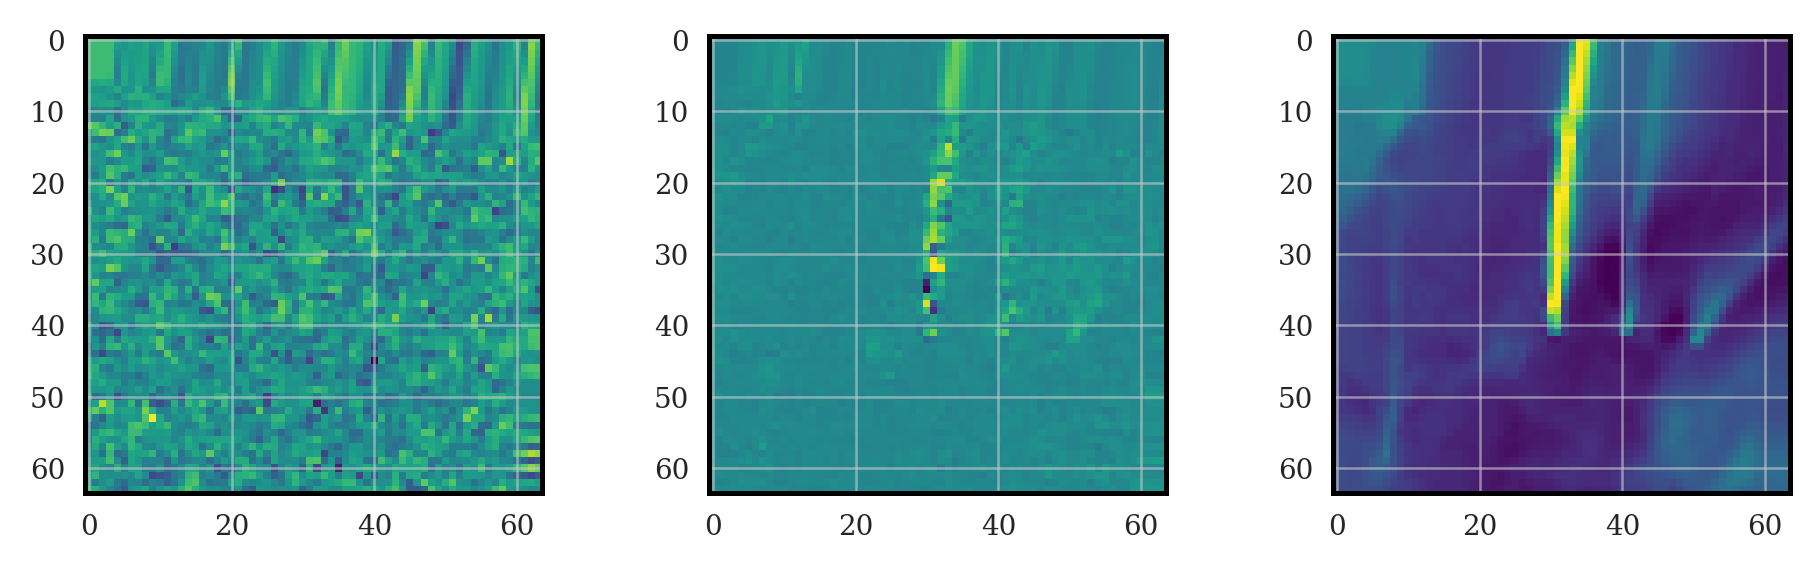

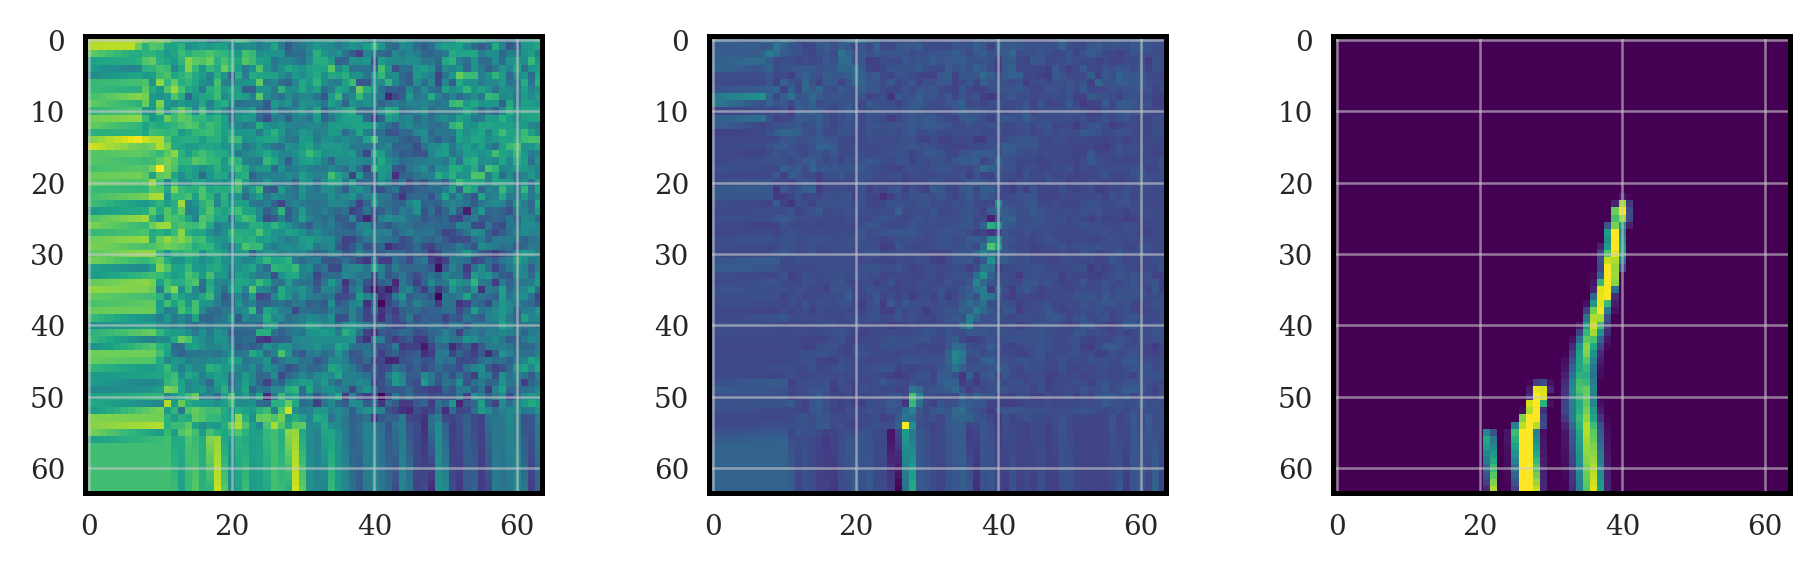

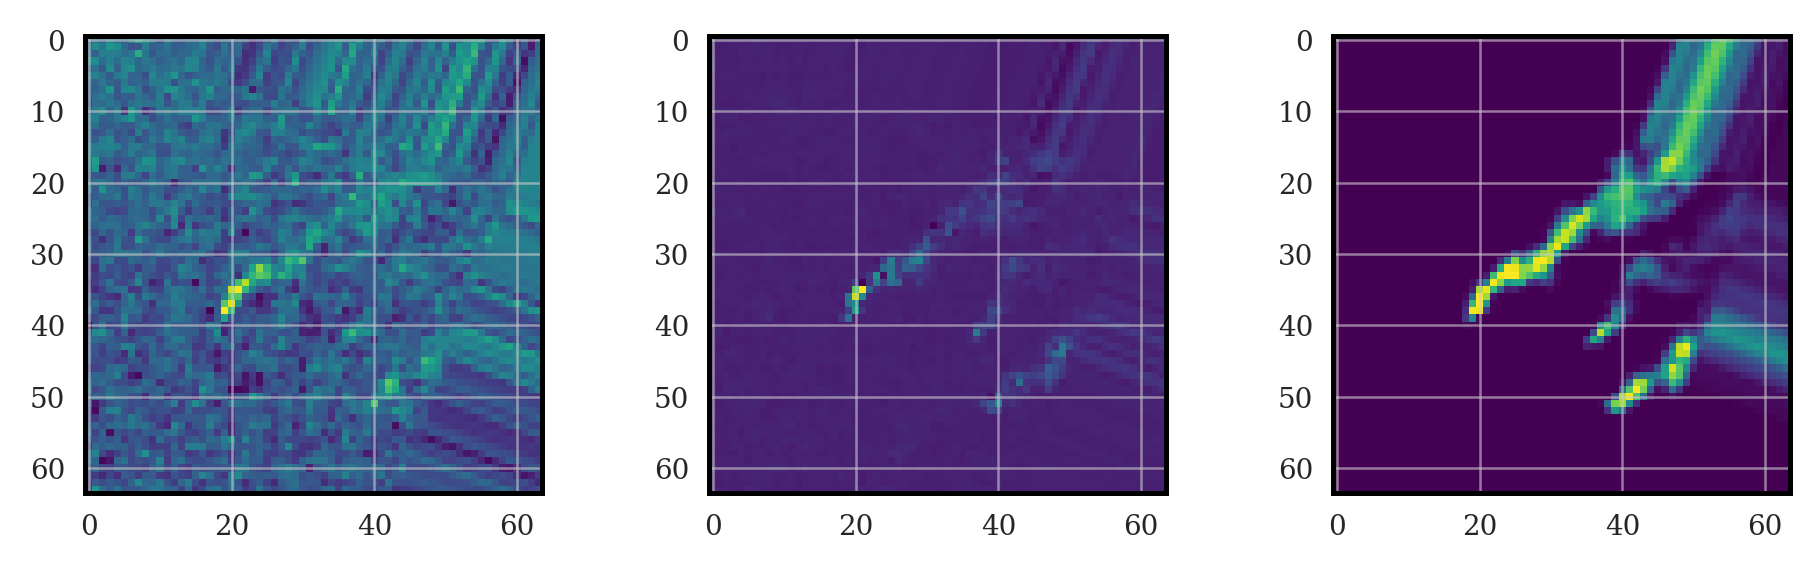

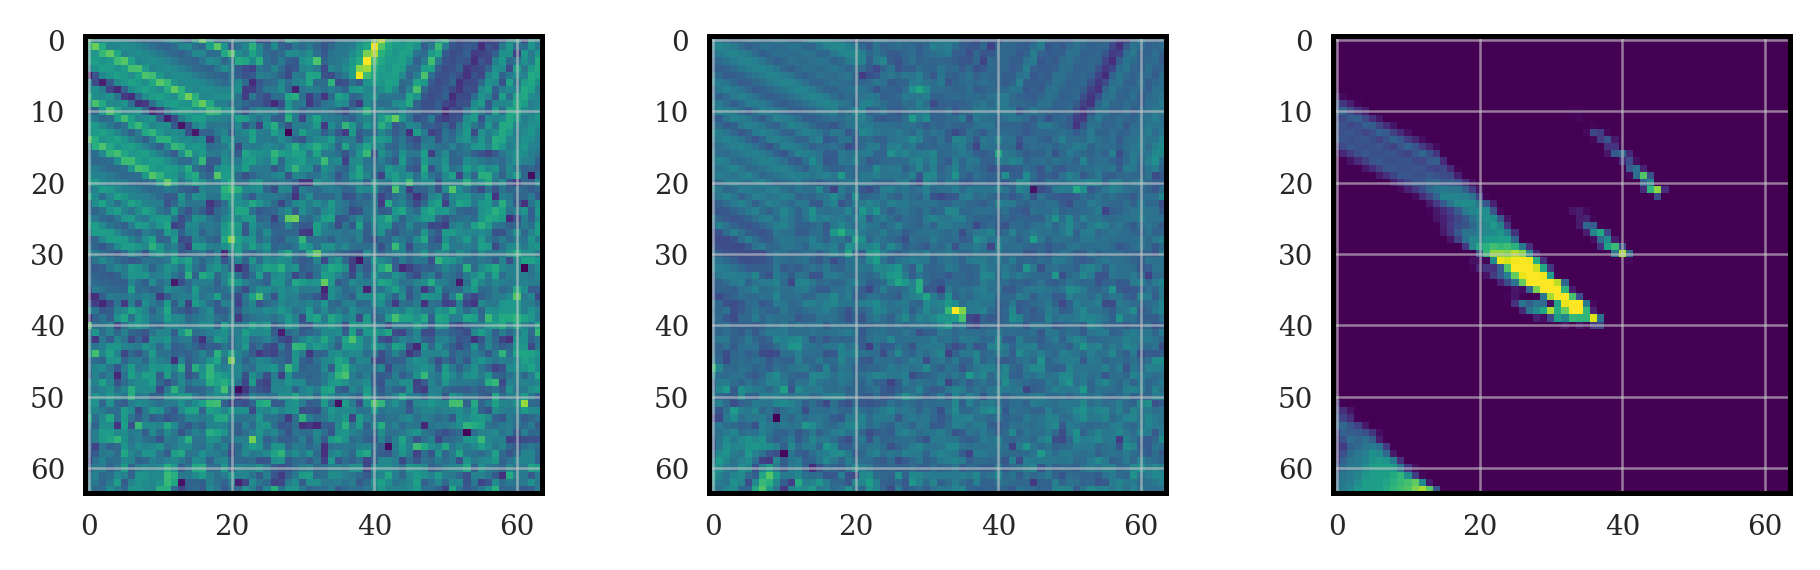

In [37]:
x = image_generator.next()
y = mask_generator.next()
for i in range(0, 4):
    image = x[i]
    mask = y[i]
    axs = mympf.set_figure_axs(1, 3, pad_w_int=0.05, pad_h_int=0.05)
    axs[0].imshow(image[:, :, 0])
    axs[1].imshow(image[:, :, 1])
    axs[2].imshow(mask[:, :, 0])
    plt.show()

In [19]:
x = image_datagen.next()
y = mask_datagen.next()
for i in range(0,4):
    image = x[i]
    mask = y[i]
    plt.imshow(image)
    plt.imshow(mask)
    plt.show()


AttributeError: 'ImageDataGenerator' object has no attribute 'next'

In [18]:
model.fit(
    train_generator,
    epochs=3,
    steps_per_epoch=2000,
    validation_data=(data.x.valid, data.y.valid),
    verbose=1,
    shuffle=True,
)

Epoch 1/3
2000/2000 [==============================] - 115s 58ms/step - loss: 0.2109 - val_loss: 1.1653
Epoch 2/3
1016/2000 [==============>...............] - ETA: 55s - loss: 0.1963

KeyboardInterrupt: 

In [52]:
model.evaluate(data.x.train, data.y.train)

1180/1180 [==============================] - 18s 15ms/step - loss: 7.3610


7.361011505126953

In [ ]:
orig_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet')
dense_input = tf.keras.layers.Input(shape=(64, 64, 6))
dense_filter = tf.keras.layers.Conv2D(3, 3, padding='same')(dense_input)
output = orig_model(dense_filter)

model = tf.keras.Model(dense_input, output)
model.compile()
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 64, 64, 6)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 3)         165       
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
Total params: 4,049,736
Trainable params: 4,007,713
Non-trainable params: 42,023
_________________________________________________________________


In [7]:
from model_training import build_model

In [11]:
model = build_model(
    "inversion",
    "EfficientNetB0",
    (64,64,6),
    1)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 64, 64, 6)]       0         
                                                                 
 efficientnetb0 (Functional)  (None, 2, 2, 1280)       4050441   
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 output_layer (Dense)        (None, 1)                 1281      
                                                                 
 activation_layer (LeakyReLU  (None, 1)                0         
 )                                                               
                                                                 
Total params: 4,051,722
Trainable params: 4,009,693
Non-tra

In [ ]:
model.compile(loss=tf.keras.losses.MeanAbsoluteError())

In [ ]:
x = np.random.normal(size=(1000,64,64,6))
y = np.random.normal(size=(1000,1))

In [ ]:
model.fit(x,y, epochs=100)

Epoch 1/100
32/32 [==============================] - 1s 44ms/step - loss: 0.3099
Epoch 2/100
32/32 [==============================] - 2s 47ms/step - loss: 0.3073
Epoch 3/100
32/32 [==============================] - 1s 41ms/step - loss: 0.2914
Epoch 4/100
32/32 [==============================] - 1s 45ms/step - loss: 0.2800
Epoch 5/100
32/32 [==============================] - 1s 42ms/step - loss: 0.2757
Epoch 6/100
32/32 [==============================] - 1s 46ms/step - loss: 0.2621
Epoch 7/100
32/32 [==============================] - 1s 46ms/step - loss: 0.2732
Epoch 8/100
32/32 [==============================] - 1s 45ms/step - loss: 0.2654
Epoch 9/100
32/32 [==============================] - 1s 43ms/step - loss: 0.2612
Epoch 10/100
32/32 [==============================] - 1s 46ms/step - loss: 0.2597
Epoch 11/100
32/32 [==============================] - 1s 43ms/step - loss: 0.2327
Epoch 12/100
32/32 [==============================] - 1s 46ms/step - loss: 0.2564
Epoch 13/100
32/32 [=====

In [1]:
from models import seg

2023-03-20 21:35:07.548065: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
mb = seg.Seg_model_builder(name="Unet_4")

In [6]:
model = mb.get_model()

2023-03-20 21:39:03.165795: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 21:39:03.691212: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 65 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5


In [8]:
import xarray as xr

In [24]:
ds = xr.open_dataset("/libre/dumontj/coco2/dl-input/2km_Tur/train_valid_dataset.nc")

In [25]:
import matplotlib_functions as mympf

In [26]:
np.random.randint(0,1000)

966

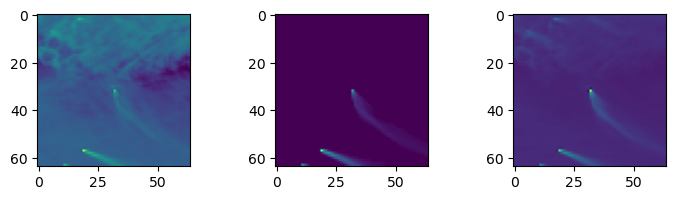

In [27]:
axs = mympf.set_figure_axs(1,3)
idx = np.random.randint(0,1000)
axs[0].imshow(np.squeeze(ds.xco2.values[idx]))
axs[1].imshow(np.squeeze(ds.plume.values[idx]))
axs[2].imshow(np.squeeze(ds.no2.values[idx]))

In [29]:
ds.emiss.mean()

<xarray.DataArray 'emiss' ()>
array(8.710552, dtype=float32)